TODO delete this after debugging test_data_correctness.py

In [3]:
import yaml, os
import numpy as np
from src.dataset import NCAR_Dataset
import xarray as xr
import zarr
import dask.array as da

config = {}
with open('tests/config.yaml', 'r') as file:
    config = yaml.safe_load(file)
dataset_name = os.environ.get('DATASET', 'NCAR-High-Rate-1')
# start_timestep = int(os.environ.get('START_TIMESTEP', 0))
start_timestep = 0
# end_timestep = int(os.environ.get('END_TIMESTEP', 2))
end_timestep = 0
prod_or_backup = str(os.environ.get('PROD_OR_BACKUP', 'prod'))

In [4]:
def generate_data_correctness_tests():
    global config, dataset_name, start_timestep, end_timestep, prod_or_backup
    if prod_or_backup != 'prod' and prod_or_backup != 'back':
        raise ValueError("prod_or_backup must be either 'prod' or 'back'")

    print("start_timestep: ", start_timestep)
    print("end_timestep: ", end_timestep)

    test_params = []
    dataset_config = config['datasets'][dataset_name]
    write_config = config['write_settings']
    dataset = NCAR_Dataset(
        name=dataset_config['name'],
        location_path=dataset_config['location_path'],
        desired_zarr_chunk_size=write_config['desired_zarr_chunk_length'],
        desired_zarr_array_length=write_config['desired_zarr_array_length'],
        prod_or_backup=prod_or_backup,
        start_timestep=dataset_config['start_timestep'],
        end_timestep=dataset_config['end_timestep']
    )

    for timestep in range(start_timestep, end_timestep + 1):
        print("Current timestep: ", timestep)
        lazy_zarr_cubes, range_list = dataset.transform_to_zarr(timestep)
        print("len of lazy_zarr_cubes: ", len(lazy_zarr_cubes))
        # print(dataset.get_zarr_array_destinations(timestep, range_list))
        destination_paths, morton_order_map = dataset.get_zarr_array_destinations(timestep, range_list)
        print("len of destination_paths: ", len(destination_paths))
        for original_data_cube, written_zarr_cube in zip(lazy_zarr_cubes, destination_paths):
            test_params.append((original_data_cube, written_zarr_cube))

        print("Done generating tests. Len of test_params: ", len(test_params))
        return test_params, morton_order_map, lazy_zarr_cubes

### First item in `test_params` should be morton-sorted

#### See how `lazy_zarr_cubes` are sorted w.r.t original JHD

In [5]:
test_params, morton_order_map, lazy_zarr_cubes = generate_data_correctness_tests()

start_timestep:  0
end_timestep:  0
Current timestep:  0
len of lazy_zarr_cubes:  64
len of destination_paths:  64
Done generating tests. Len of test_params:  64


##### <font color='orange'>Check if test_params[i] always matches lazy_zarr_cubes[i]</font>

In [6]:
# a = [np.array_equal(lazy_zarr_cubes[i]['energy'][:10,0,0].to_numpy(), test_params[i][0]['energy'][:10,0,0].to_numpy()) for i in range(len(lazy_zarr_cubes))]

# np.all(a)

##### <font color='orange'>Yes they do, now see where they are w.r.t original .ncar</font>

In [7]:
var = 'p'
variable = 'pressure'

In [8]:
original_xr = xr.open_dataset('/home/idies/workspace/turb/data02_02/ncar-high-rate-fixed-dt/jhd.000.nc')
orig_xr_var = original_xr[var]

## Matching subvectors to match cubes

In [7]:
orig_xr_var[512:522,0,0].data

array([-0.04845127, -0.03599769, -0.0159447 , -0.00883896, -0.02170556,
       -0.01608632,  0.00584727, -0.00107904, -0.03572638, -0.02354553],
      dtype=float32)

In [9]:
# ChatGPT
def find_subvector(large_vector, small_vector, tolerance=1e-5):
    len_sv = len(small_vector)
    len_lv = len(large_vector)

    for i in range(len_lv - len_sv + 1):
        if np.allclose(np.squeeze(large_vector[i:i+len_sv]), np.squeeze(small_vector), atol=tolerance):
            return i
    return -1  # Return -1 or another indicator if the subvector is not found

In [10]:
big_var_np = orig_xr_var.to_numpy()

In [13]:
find_subvector(big_var_np[:,0,0], test_params[1][0][variable][:10,0,0].to_numpy())

512

In [14]:
find_subvector(big_var_np[:,0,0], test_params[2][0][variable][:10,0,0].to_numpy())

1024

In [15]:
find_subvector(big_var_np[:,0,0], test_params[3][0][variable][:10,0,0].to_numpy())

1536

#### <font color='purple'>Checking 4, switching to vector search on y</font>

In [14]:
find_subvector(big_var_np[:,512,0], test_params[4][0][variable][:10,0,0].to_numpy())

0

In [16]:
find_subvector(big_var_np[:,512,512], test_params[5][0][variable][:10,0,0].to_numpy())

-1

#### <font color="red">Can't compare to Energy bcs. it has lots of `1e-09`</font>

In [83]:
idx = find_subvector(big_energy_np[:,0,0], test_params[3][0]['energy'][:10,0,0].to_numpy())
idx

957

In [60]:
big_energy_np[:10,0,0]

array([0.04783596, 0.0667972 , 0.05857512, 0.06649811, 0.10309836,
       0.0586968 , 0.0500013 , 0.0134509 , 0.0213005 , 0.01665777],
      dtype=float32)

In [84]:
test_params[2][0]['energy'][:10,0,0].to_numpy()

array([[1.e-09],
       [1.e-09],
       [1.e-09],
       [1.e-09],
       [1.e-09],
       [1.e-09],
       [1.e-09],
       [1.e-09],
       [1.e-09],
       [1.e-09]], dtype=float32)

In [69]:
test_params[1][0]['energy'][:10,0,0].to_numpy()

array([[0.00068827],
       [0.00315874],
       [0.0036105 ],
       [0.00305835],
       [0.00284837],
       [0.00276382],
       [0.00255311],
       [0.00260957],
       [0.00255635],
       [0.00266108]], dtype=float32)

## Something

In [ ]:
def test_zarr_group_data(original_subarray, zarr_group_path):
    '''
    Verify correctness of data contained in each zarr group against
    the original data file (NCAR NetCDF)

    Args:
        original_subarray (xarray.Dataset): (Sub)Array of original data that was written as zarr to zar_group_path
        zarr_group_path (str): Location of the sub-chunked data as a Zarr Group
    '''
    zarr_group = zarr.open_group(zarr_group_path, mode='r')
    print("Comparing original 512^3 with ", zarr_group_path)
    # for var in original_subarray.data_vars:
    
    var = 'energy'
    # set_trace()
    # assert_eq(original_subarray[var].data, da.from_zarr(zarr_group[var]))
    return da.assert_eq(original_subarray[var].data, da.from_zarr(zarr_group[var]))

In [ ]:
test_zarr_group_data(test_params[1][0], test_params[4][1])

Comparing original 512^3 with  /home/idies/workspace/turb/data03_01/zarr/sabl2048b_03_prod/sabl2048b03_000.zarr


/home/idies/mambaforge/envs/py39/lib/python3.9/site-packages/dask/array/core.py:1712: FutureWarning: The `numpy.array_equal` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


In [ ]:
test_zarr_group_data(test_params[1][0], test_params[9][1])

In [ ]:
morton = (write_utils.morton_pack(self.original_array_length, min_coord[2], min_coord[1], min_coord[0]),
          write_utils.morton_pack(self.original_array_length, max_coord[2], max_coord[1], max_coord[0]))

chunk_name = write_utils.search_dict_by_value(chunk_morton_mapping, morton)

In [10]:
morton_order_map

{'sabl2048b01': (0, 134217727),
 'sabl2048b02': (134217728, 268435455),
 'sabl2048b03': (268435456, 402653183),
 'sabl2048b04': (402653184, 536870911),
 'sabl2048b05': (536870912, 671088639),
 'sabl2048b06': (671088640, 805306367),
 'sabl2048b07': (805306368, 939524095),
 'sabl2048b08': (939524096, 1073741823),
 'sabl2048b09': (1073741824, 1207959551),
 'sabl2048b10': (1207959552, 1342177279),
 'sabl2048b11': (1342177280, 1476395007),
 'sabl2048b12': (1476395008, 1610612735),
 'sabl2048b13': (1610612736, 1744830463),
 'sabl2048b14': (1744830464, 1879048191),
 'sabl2048b15': (1879048192, 2013265919),
 'sabl2048b16': (2013265920, 2147483647),
 'sabl2048b17': (2147483648, 2281701375),
 'sabl2048b18': (2281701376, 2415919103),
 'sabl2048b19': (2415919104, 2550136831),
 'sabl2048b20': (2550136832, 2684354559),
 'sabl2048b21': (2684354560, 2818572287),
 'sabl2048b22': (2818572288, 2952790015),
 'sabl2048b23': (2952790016, 3087007743),
 'sabl2048b24': (3087007744, 3221225471),
 'sabl2048b25':

In [24]:
for i in range(64):
    print(i, test_zarr_group_data(test_params[i][0], test_params[i][1]))

Comparing original 512^3 with  /home/idies/workspace/turb/data01_01/zarr/sabl2048a_01_prod/sabl2048a01_001.zarr
0 True
Comparing original 512^3 with  /home/idies/workspace/turb/data02_01/zarr/sabl2048a_02_prod/sabl2048a02_001.zarr
1 False
Comparing original 512^3 with  /home/idies/workspace/turb/data09_01/zarr/sabl2048a_09_prod/sabl2048a09_001.zarr
2 False
Comparing original 512^3 with  /home/idies/workspace/turb/data10_01/zarr/sabl2048a_10_prod/sabl2048a10_001.zarr
3 False
Comparing original 512^3 with  /home/idies/workspace/turb/data03_01/zarr/sabl2048a_03_prod/sabl2048a03_001.zarr
4 True
Comparing original 512^3 with  /home/idies/workspace/turb/data04_01/zarr/sabl2048a_04_prod/sabl2048a04_001.zarr
5 False
Comparing original 512^3 with  /home/idies/workspace/turb/data11_01/zarr/sabl2048a_11_prod/sabl2048a11_001.zarr
6 False
Comparing original 512^3 with  /home/idies/workspace/turb/data12_01/zarr/sabl2048a_12_prod/sabl2048a12_001.zarr
7 False
Comparing original 512^3 with  /home/idies


KeyboardInterrupt



### Notice how 000(1) passes!

This is because morton 1 => 1. But 2 => 9!

<font color='red'>Check morton ordering!</font>

In [29]:
test_params[1]

(<xarray.Dataset>
 Dimensions:      (nnz: 512, nny: 512, nnx: 512, extra_dim: 1,
                   velocity component (xyz): 3)
 Dimensions without coordinates: nnz, nny, nnx, extra_dim,
                                 velocity component (xyz)
 Data variables:
     temperature  (nnz, nny, nnx, extra_dim) float32 dask.array<chunksize=(64, 64, 64, 1), meta=np.ndarray>
     pressure     (nnz, nny, nnx, extra_dim) float32 dask.array<chunksize=(64, 64, 64, 1), meta=np.ndarray>
     energy       (nnz, nny, nnx, extra_dim) float32 dask.array<chunksize=(64, 64, 64, 1), meta=np.ndarray>
     velocity     (nnz, nny, nnx, velocity component (xyz)) float32 dask.array<chunksize=(64, 64, 64, 3), meta=np.ndarray>
 Attributes:
     Simulation conducted by:  Peter Sullivan, pps@ucar.edu
     Dataset built by:         Edward Patton, patton@ucar.edu
     Affiliation:              NCAR/MMM
     Code:                     NCAR-LES
     Case Description:         GABLS 1, Cooling Rate: 0.25 K/hr
     Create

In [8]:
import numpy as np

In [ ]:
np.array(test_params[2][0]['energy'][:20,:2,0])

In [8]:
test_numpy = np.array(test_params[2][0]['energy'])

In [9]:
test_numpy = np.squeeze(test_numpy)
test_numpy.shape

(512, 512, 512)

In [34]:
np.array_equal(zarr_np, test_numpy)

False

In [39]:
test_params[0][0]['energy'][:10,0,0].to_numpy()

array([[0.00752075],
       [0.0392309 ],
       [0.05089123],
       [0.06427825],
       [0.02803861],
       [0.02672213],
       [0.0192969 ],
       [0.02235718],
       [0.02305493],
       [0.02512459]], dtype=float32)

In [38]:
test_params[1][0]['energy'][:10,0,0].to_numpy()

array([[0.00138608],
       [0.00146217],
       [0.00179216],
       [0.00161177],
       [0.00178566],
       [0.00193972],
       [0.00170522],
       [0.0018154 ],
       [0.00143121],
       [0.00148491]], dtype=float32)

In [37]:
test_params[2][0]['energy'][:10,0,0].to_numpy()

array([[1.e-09],
       [1.e-09],
       [1.e-09],
       [1.e-09],
       [1.e-09],
       [1.e-09],
       [1.e-09],
       [1.e-09],
       [1.e-09],
       [1.e-09]], dtype=float32)

In [40]:
test_params[3][0]['energy'][:10,0,0].to_numpy()

array([[1.e-09],
       [1.e-09],
       [1.e-09],
       [1.e-09],
       [1.e-09],
       [1.e-09],
       [1.e-09],
       [1.e-09],
       [1.e-09],
       [1.e-09]], dtype=float32)

In [17]:
zarr_np[:10,0,0]

array([0.04115582, 0.04915426, 0.04164662, 0.03024624, 0.02043892,
       0.02810379, 0.02732361, 0.03903302, 0.04433993, 0.04363097],
      dtype=float32)

#### Print out some lines from original $2048^3$

In [6]:
import xarray as xr

xr_energy = xr.open_dataset('/home/idies/workspace/turb/data02_02/ncar-low-rate-fixed-dt/jhd.001.nc', mode='r')['e']
xr_energy

<xarray.DataArray 'e' (nnz: 2048, nny: 2048, nnx: 2048)>
[8589934592 values with dtype=float32]
Dimensions without coordinates: nnz, nny, nnx
Attributes:
    Description:  Subfilter-scale energy, e
    Units:        [m^2/s^2]

In [62]:
xr_energy[:10,0,0].to_numpy()

array([0.00752075, 0.0392309 , 0.05089123, 0.06427825, 0.02803861,
       0.02672213, 0.0192969 , 0.02235718, 0.02305493, 0.02512459],
      dtype=float32)

In [63]:
test_params[0][0]['energy'][:10,0,0].to_numpy()

array([[0.00752075],
       [0.0392309 ],
       [0.05089123],
       [0.06427825],
       [0.02803861],
       [0.02672213],
       [0.0192969 ],
       [0.02235718],
       [0.02305493],
       [0.02512459]], dtype=float32)

#### <font color='purple'>Search through list of test_params for match of first 10 elements of `xr_energy`</font>

In [10]:
tmp = xr_energy[:10,0,0].to_numpy()

for i in range(len(test_params)):
    if np.all(np.isclose(np.squeeze(test_params[i][0]['energy'][:10,0,0].to_numpy()), tmp)):
        print(i)

0


### <font color='purple'>Do the reverse - find element in big array</font>

In [75]:
big_energy_np = xr_energy.to_numpy()

In [76]:
indices = np.where(big_energy_np == 0.00138608)
indices

(array([116, 211, 309, 324, 331, 333, 334, 338, 349, 356, 357, 361, 370,
        373, 378, 391, 395, 398, 401, 408, 423, 432, 440, 443, 443, 450,
        456, 458, 459, 468, 468, 484, 485, 487, 506, 507, 511, 526, 534,
        542, 544, 547, 549, 563, 573, 578, 582, 587, 592, 594, 595, 596,
        602, 606, 612, 622, 637, 669, 679, 699, 705]),
 array([1866,  376,  130,  904,  169, 1180, 1879, 1957, 1375,  212,  276,
        1405,  644,  178, 1396,  331,  163, 1529, 1333,  762, 1616, 1428,
         379, 1296, 1465,  481, 1378, 2035, 1667,  420,  979, 1114,  646,
        1030,  728,  149,  524, 1964, 1758, 2039, 1935,  630, 1505, 1707,
        1280,  314, 1957,  978, 1518,  951,  288,  251, 1995,  364,  816,
         157,  997, 1007, 1284, 1065, 1874]),
 array([1853,  599,  683,  663,  514,   83,  527,  792,  448,  284, 1421,
        1590,  494, 1007,  475,  163,  570,  834,  370, 1189, 1705,  703,
         653,  528,  387, 1743, 1426, 1326, 1622, 1942, 1536,  793, 1695,
        1676,  

In [81]:
big_energy_np[511:521, 0,0]

array([0.00139909, 0.00138608, 0.00146217, 0.00179216, 0.00161177,
       0.00178566, 0.00193972, 0.00170522, 0.0018154 , 0.00143121],
      dtype=float32)

In [82]:
test_params[1][0]['energy'][:10,0,0].to_numpy()

array([[0.00138608],
       [0.00146217],
       [0.00179216],
       [0.00161177],
       [0.00178566],
       [0.00193972],
       [0.00170522],
       [0.0018154 ],
       [0.00143121],
       [0.00148491]], dtype=float32)

### <font color='red'>See, something is wrong with the Morton ordering of the inputs to `test_params`</font>

#### <font color='red'>Make sure the dataset you open manually has the correct timestep</font>

### Plot to verify

In [22]:
from matplotlib import pyplot as plt

In [23]:
zarr_np.shape

(512, 512, 512)

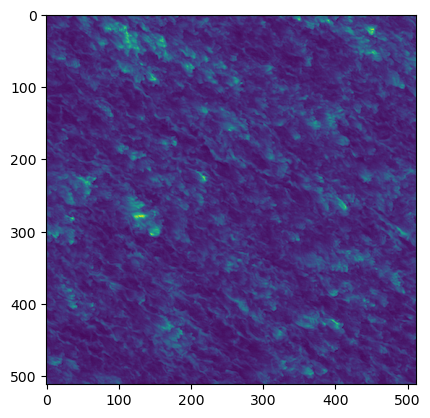

In [24]:
plt.imshow(zarr_np[0,:,:])

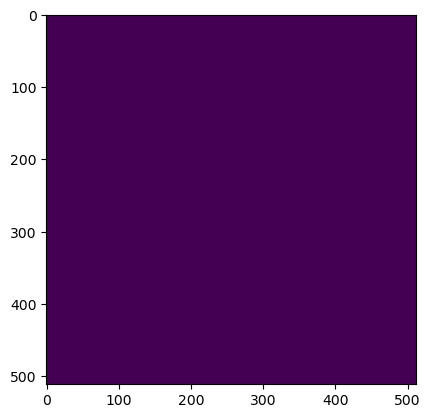

In [25]:
plt.imshow(np.squeeze(test_numpy[0,:,:]))

In [26]:
np.all(np.squeeze(test_numpy[0,:,:]) == 1e-09)

True

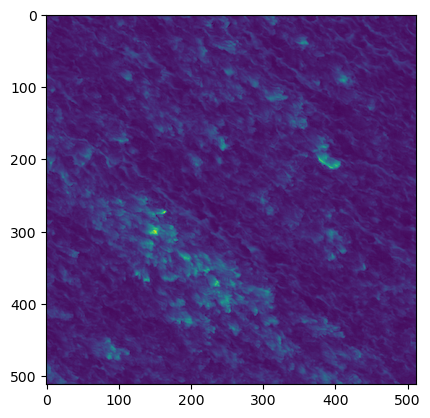

In [27]:
plt.imshow(np.squeeze(zarr.open_group(test_params[0][1], mode='r')['energy'][0,:,:]))

In [28]:
test_params[0][0]

<xarray.Dataset>
Dimensions:      (nnz: 512, nny: 512, nnx: 512, extra_dim: 1,
                  velocity component (xyz): 3)
Dimensions without coordinates: nnz, nny, nnx, extra_dim,
                                velocity component (xyz)
Data variables:
    temperature  (nnz, nny, nnx, extra_dim) float32 dask.array<chunksize=(64, 64, 64, 1), meta=np.ndarray>
    pressure     (nnz, nny, nnx, extra_dim) float32 dask.array<chunksize=(64, 64, 64, 1), meta=np.ndarray>
    energy       (nnz, nny, nnx, extra_dim) float32 dask.array<chunksize=(64, 64, 64, 1), meta=np.ndarray>
    velocity     (nnz, nny, nnx, velocity component (xyz)) float32 dask.array<chunksize=(64, 64, 64, 3), meta=np.ndarray>
Attributes:
    Simulation conducted by:  Peter Sullivan, pps@ucar.edu
    Dataset built by:         Edward Patton, patton@ucar.edu
    Affiliation:              NCAR/MMM
    Code:                     NCAR-LES
    Case Description:         GABLS 1, Cooling Rate: 0.25 K/hr
    Created:                  2023-12-26 16:29:42 -0700 UTC

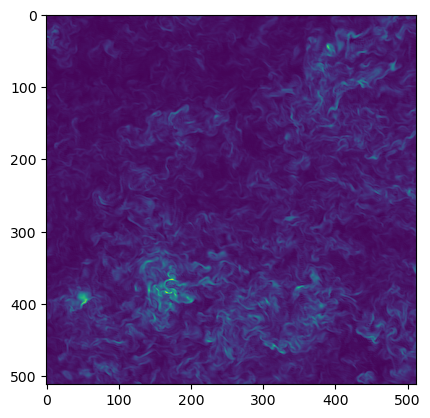

In [29]:
plt.imshow(np.array(test_params[1][0]['energy'][0,:,:]))

In [30]:
!pwd

/home/idies/workspace/Storage/ariel4/persistent/zarrify-across-network


In [31]:
import xarray as xr

original_xr_lr_0 = xr.open_dataset("/home/idies/workspace/turb/data02_02/ncar-low-rate-fixed-dt/jhd.000.nc")

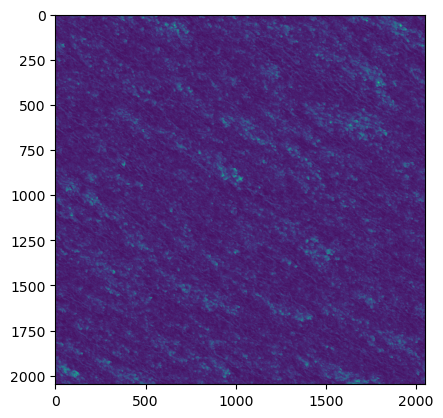

In [32]:
plt.imshow(original_xr_lr_0['e'][0,:,:])

In [33]:
np.array(original_xr_lr_0['e'][0,:,:])

array([[0.06224451, 0.05349654, 0.04688744, ..., 0.04459177, 0.04466303,
        0.05529598],
       [0.0608885 , 0.05288706, 0.04441363, ..., 0.04390285, 0.04897266,
        0.05781338],
       [0.06233034, 0.05678486, 0.04853922, ..., 0.05863234, 0.06729572,
        0.06807955],
       ...,
       [0.03273902, 0.02835527, 0.04340629, ..., 0.05029881, 0.05742294,
        0.05080393],
       [0.04399356, 0.02537068, 0.02552195, ..., 0.03249297, 0.04397909,
        0.05320001],
       [0.05449326, 0.04235811, 0.03621788, ..., 0.03596082, 0.04094118,
        0.05175808]], dtype=float32)